# 고양이 수염 스티커 만들기

In [1]:
# 사용되는 주요 라이브러리 버전 확인
import cv2
import dlib

print(cv2.__version__)
print(dlib.__version__)

4.5.3
19.22.1


In [2]:
# 필요한 패키지 import
import os
import matplotlib.pyplot as plt
import numpy as np

## Step 1. 고양이 스티커 받기

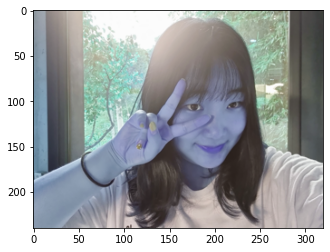

In [3]:
# 사진 준비하기
my_image_path = 'aiffel/camera_sticker/images/image_sy.png'
img_bgr = cv2.imread(my_image_path) # OpenCV로 이미지 불러오기
img_show = img_bgr.copy() # 출력용 이미지 따로 보관
plt.imshow(img_bgr) # 이미지 출력을 위해 출력할 이미지 올리기
plt.show()

- OpenCV에서는 이미지 채널을 BGR로 사용하기 때문에 사진 색상이 이상하게 나온다. 이것을 RGB로 보정해주어야 할 필요가 있다.

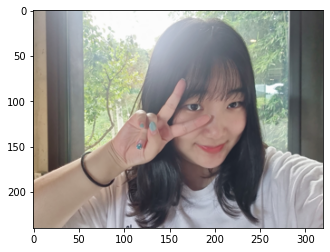

In [4]:
# 색깔 보정하기
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## Step 2. 얼굴 검출 & 랜드마크 검출 하기

### 얼굴 검출

In [5]:
# dlib의 hog detector 선언
detector_hog = dlib.get_frontal_face_detector()

In [6]:
# detector_hog를 이용해 얼굴의 bounding box를 추출
dlib_rects = detector_hog(img_rgb, 1) # (image, num of image pyramid)

rectangles[[(155, 76) (245, 166)]]


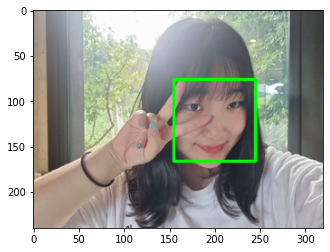

In [7]:
# 얼굴의 bounding box 찾기
print(dlib_rects)

# 찾은 얼굴 영역의 좌표
for dlib_rect in dlib_rects:
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽
    
    # 시작점의 좌표와 종료점 좌표를 직각 사각형으로 그리기
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

![dlib](https://user-images.githubusercontent.com/116326867/204445972-67843855-121c-4967-9b7b-6780c220d589.png)

- Dlib의 제공되는 모델을 사용하기 위해 공개되어 있는 weight file을 다운로드. bz2 압축파일 형태로 제공되어 압축을 풀어준 후 사용한다.

### 얼굴 랜드마크 검출

In [8]:
# 저장한 landmark 모델 불러오기
model_path = 'aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
# shape_predictor : 모델을 불러오는 함수
# landmark_predictor : RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
# dlib.rectangle: 내부를 예측하는 박스
# dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄

In [9]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark 찾아내기 - face landmark 좌표 저장
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect) # 모든 landmark의 위치정보를 points변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts())) # landmark 위치정보를 (x,y)형태로 변환 후 list_points에 리스트로 저장
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))
# part() : 개별 위치에 접근할 수 있는 함수
# list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장되므로 현재 이미지의 list_landmarks의 원소는 1개
# 각 원소는 68개의 랜드마크 위치가 나열된 list

68


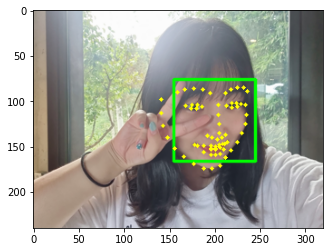

In [10]:
# 랜드마크를 영상에 출력해보기
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0,255, 255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## Step 3. 스티커 적용 위치 확인하기
- 각 부위 index -> 고양이 수염이 코 위에 올려져야 하므로 30번으로 선택

![각 부위 index](https://user-images.githubusercontent.com/116326867/204451726-3ccda6ec-1a73-4c45-852c-70afbcd696c1.png)

## Step 4. 스티커 적용하기

In [11]:
# 죄표 확인하기
# 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30]) # 원하는 위치의 index는 30
    x = landmark[30][0] # 이미지에서 코 부위의 x값
    y = landmark[30][1] - dlib_rect.height()//2 # 이미지에서 미간 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2
    w = h = dlib_rect.width() # 얼굴 영역의 가로 픽셀의 수
    print(f'(x,y) : ({x},{y})')
    print(f'(w,h) : ({w},{h})')

(205, 135)
(x,y) : (205,90)
(w,h) : (91,91)


- zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수(dlib_rects와 list_landmarks 데이터를 엮어주기)
- dlib_rects : 얼굴 영역을 저장하고 있는 값 → rectangles[[(155, 76) (245, 166)]]
- list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))
- 코의 중심점 : (205, 135) / 코 부위 x,y값 = 205,90 / 얼굴영역 가로,세로를 차지하는 픽셀 수 = 91,91

In [12]:
# 고양이 수염 스티커 이미지 읽어오기 및 resize
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

(91, 91, 3)


In [13]:
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정. 이미지 시작점은 top-left 좌표이기 때문.
# refined_x, refined_y값에서 고양이 수염 이미지가 시작된다는 의미.
refined_x = x - w // 2 - 5
refined_y = y + 4
print(f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (155,94)


In [14]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# sticker_area : 원본이미지에서 스티커를 적용할 위치를 crop한 이미지
# 좌표 순서가 y,x임에 유의할 것 (y,x,rgb channel)
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

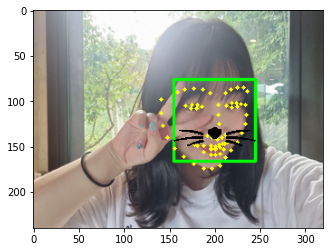

In [15]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- np.where(조건, TRUE, FALSE)  
np.where(img_sticker==0,sticker_area,img_sticker) -> 고양이 수염이 없어지고 흰색 배경만 남음.  
np.where(img_sticker==0,img_sticker,sticker_area) -> 고양이 수염만 남음.  
np.where(img_sticker==255,sticker_area,img_sticker) -> 고양이 수염만 남음.  
np.where(img_sticker!=0,img_sticker,sticker_area) -> 고양이 수염만 남음.  

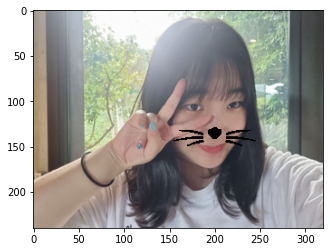

In [16]:
# 고양이 수염 이미지
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)
# img_bgr은 rgb로만 적용해놓은 원본 이미지

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 고양이 수염 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

## Step 5. 문제점 찾아보기
- 얼굴 각도에 따라 스티커가 어떻게 변해야하는가?
- 멀리서 촬영하면 왜 안되는가? 옆으로 누워서 촬영하면 왜 안되는가?
- 실행 속도가 중요한가?
- 스티커앱을 만들 때 정확도가 얼마나 중요한가?

### (1) 사진이 어두운 경우 인식이 잘 되는가? 얼굴이 여러개인 경우 어떻게 인식이 되는가? 얼굴 각도에 따라 스티커가 어떻게 변해야하는가?

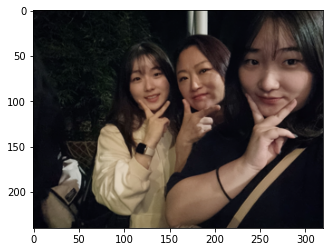

In [17]:
# 사진 준비하기(색깔 보정해서 준비)
my_image_path_2 = 'aiffel/camera_sticker/images/image_sy_2.png'
img_bgr_2 = cv2.imread(my_image_path_2) # OpenCV로 이미지 불러오기
img_show = img_bgr_2.copy() # 출력용 이미지 따로 보관
img_rgb_2 = cv2.cvtColor(img_bgr_2, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_2) # 이미지 출력을 위해 출력할 이미지 올리기
plt.show()

rectangles[[(101, 55) (152, 107)], [(215, 36) (305, 126)], [(158, 55) (210, 107)]]


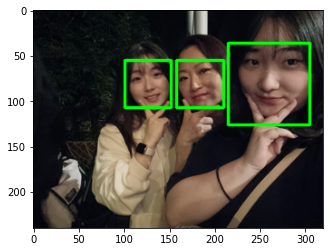

In [18]:
# dlib의 hog detector 선언
detector_hog = dlib.get_frontal_face_detector()

# detector_hog를 이용해 얼굴의 bounding box를 추출
dlib_rects = detector_hog(img_rgb_2, 1) # (image, num of image pyramid)

# 얼굴의 bounding box 찾기
print(dlib_rects)

# 찾은 얼굴 영역의 좌표
for dlib_rect in dlib_rects:
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽
    
    # 시작점의 좌표와 종료점 좌표를 직각 사각형으로 그리기
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

68


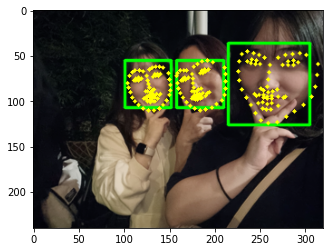

In [19]:
# 저장한 landmark 모델 불러오기
model_path = 'aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark 찾아내기 - face landmark 좌표 저장
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb_2, dlib_rect) # 모든 landmark의 위치정보를 points변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts())) # landmark 위치정보를 (x,y)형태로 변환 후 list_points에 리스트로 저장
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

# 랜드마크를 영상에 출력해보기
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0,255, 255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [20]:
# 죄표 확인하기
# 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30]) # 원하는 위치의 index는 30
    x = landmark[30][0] # 이미지에서 코 부위의 x값
    y = landmark[30][1] - dlib_rect.height()//2 # 이미지에서 미간 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2
    w = h = dlib_rect.width() # 얼굴 영역의 가로 픽셀의 수
    print(f'(x,y) : ({x},{y})')
    print(f'(w,h) : ({w},{h})')

(128, 85)
(x,y) : (128,59)
(w,h) : (52,52)
(258, 84)
(x,y) : (258,39)
(w,h) : (91,91)
(177, 85)
(x,y) : (177,59)
(w,h) : (53,53)


In [25]:
# 고양이 수염 스티커 이미지 읽어오기 및 resize
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker_1 = cv2.resize(img_sticker, (91,91))
print(img_sticker_1.shape)
img_sticker_2 = cv2.resize(img_sticker, (53,53))
print(img_sticker_2.shape)
img_sticker_3 = cv2.resize(img_sticker, (52,52))
print(img_sticker_3.shape)

(91, 91, 3)
(53, 53, 3)
(52, 52, 3)


In [29]:
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정. 이미지 시작점은 top-left 좌표이기 때문.
# refined_x, refined_y값에서 고양이 수염 이미지가 시작된다는 의미.
refined_x_1 = 253 - 91 // 2
refined_y_1 = 39 + 4
print(f'(x_1,y_1) : ({refined_x_1},{refined_y_1})')
refined_x_2 = 177 - 53 // 2
refined_y_2 = 59 + 4
print(f'(x_2,y_2) : ({refined_x_2},{refined_y_2})')
refined_x_3 = 128 - 52 // 2
refined_y_3 = 59 + 4
print(f'(x_3,y_3) : ({refined_x_3},{refined_y_3})')

(x_1,y_1) : (208,43)
(x_2,y_2) : (151,63)
(x_3,y_3) : (102,63)


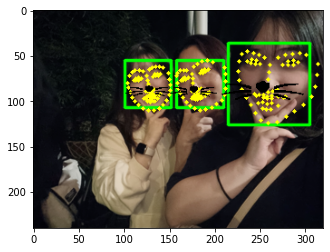

In [30]:
sticker_area_1 = img_show[refined_y_1:refined_y_1+img_sticker_1.shape[0], refined_x_1:refined_x_1+img_sticker_1.shape[1]]
# sticker_area : 원본이미지에서 스티커를 적용할 위치를 crop한 이미지
# 좌표 순서가 y,x임에 유의할 것 (y,x,rgb channel)
img_show[refined_y_1:refined_y_1+img_sticker_1.shape[0], refined_x_1:refined_x_1+img_sticker_1.shape[1]] = \
    np.where(img_sticker_1==0,img_sticker_1,sticker_area_1).astype(np.uint8)

sticker_area_2 = img_show[refined_y_2:refined_y_2+img_sticker_2.shape[0], refined_x_2:refined_x_2+img_sticker_2.shape[1]]
img_show[refined_y_2:refined_y_2+img_sticker_2.shape[0], refined_x_2:refined_x_2+img_sticker_2.shape[1]] = \
    np.where(img_sticker_2==0,img_sticker_2,sticker_area_2).astype(np.uint8)

sticker_area_3 = img_show[refined_y_3:refined_y_3+img_sticker_3.shape[0], refined_x_3:refined_x_3+img_sticker_3.shape[1]]
img_show[refined_y_3:refined_y_3+img_sticker_3.shape[0], refined_x_3:refined_x_3+img_sticker_3.shape[1]] = \
    np.where(img_sticker_3==0,img_sticker_3,sticker_area_3).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

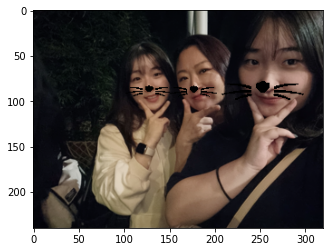

In [31]:
# 고양이 수염 이미지
sticker_area_1 = img_bgr_2[refined_y_1:refined_y_1+img_sticker_1.shape[0], refined_x_1:refined_x_1+img_sticker_1.shape[1]]

img_bgr_2[refined_y_1:refined_y_1 +img_sticker_1.shape[0], refined_x_1:refined_x_1+img_sticker_1.shape[1]] = \
    np.where(img_sticker_1==0,img_sticker_1,sticker_area_1).astype(np.uint8)
# img_bgr은 rgb로만 적용해놓은 원본 이미지

sticker_area_2 = img_bgr_2[refined_y_2:refined_y_2+img_sticker_2.shape[0], refined_x_2:refined_x_2+img_sticker_2.shape[1]]

img_bgr_2[refined_y_2:refined_y_2 +img_sticker_2.shape[0], refined_x_2:refined_x_2+img_sticker_2.shape[1]] = \
    np.where(img_sticker_2==0,img_sticker_2,sticker_area_2).astype(np.uint8)

sticker_area_3 = img_bgr_2[refined_y_3:refined_y_3+img_sticker_3.shape[0], refined_x_3:refined_x_3+img_sticker_3.shape[1]]

img_bgr_2[refined_y_3:refined_y_3 +img_sticker_3.shape[0], refined_x_3:refined_x_3+img_sticker_3.shape[1]] = \
    np.where(img_sticker_3==0,img_sticker_3,sticker_area_3).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr_2, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 고양이 수염 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

(53, 53, 3)


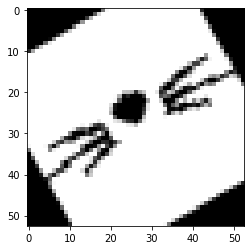

In [40]:
# getRotationMatrix2D
# 고양이 수염 스티커 이미지 읽어오기 및 resize 후 rotate
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))

# 이미지의 크기를 잡고 이미지의 중심을 계산
(h, w) = img_sticker.shape[:2]
(cX, cY) = (w // 2, h // 2)

# 이미지의 중심을 중심으로 이미지를 30도 회전
M = cv2.getRotationMatrix2D((cX, cY), 30, 1.0)
img_sticker_rotated = cv2.warpAffine(img_sticker, M, (w, h))

plt.imshow(img_sticker_rotated)
print(img_sticker_rotated.shape)

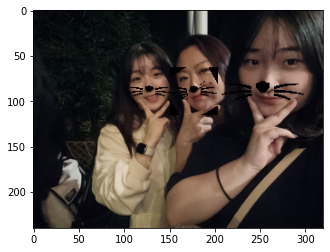

In [41]:
sticker_area_rotated = img_bgr_2[refined_y_2:refined_y_2+img_sticker_rotated.shape[0], refined_x_2:refined_x_2+img_sticker_rotated.shape[1]]

img_bgr_2[refined_y_2:refined_y_2 +img_sticker_2.shape[0], refined_x_2:refined_x_2+img_sticker_rotated.shape[1]] = \
    np.where(img_sticker_rotated==0,img_sticker_rotated,sticker_area_rotated).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr_2, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 고양이 수염 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

1. 사진이 어두워도 인식하는 데에는 크게 문제가 없었다.  
2. 문제는 얼굴이 여러개인 경우인데, bounding box나 랜드마크를 찾아내는 것까지는 문제가 없었지만 고양이 수염을 붙일 때 문제가 발생했다. 문제가 발생한 이유는 얼굴이 1개인 경우와 똑같은 코드를 사용해주었기 때문이다. x, y, w, h 좌표를 뽑은 후에 고양이 수염 사진을 resize했는데, 이때 마지막에 나온 좌표에만 맞추어 resize되었고, 그 좌표에 해당하는 인물에게만 고양이 수염이 나왔다. 이를 해결하기 위해서는 각 bounding box에 따른 랜드마크 리스트를 나누어준 후 for 반복문을 사용해서 resize를 하면 될 거 같다는 생각이 들었다. 하지만 이 생각을 코드화하기에 내 실력이 많이 부족해서 이런저런 방법으로 해봤지만 결국 코드로 실현하지는 못했다. for문 사용은 실패했지만 숫자를 하나하나 넣어서 얼굴 3개에 고양이 수염을 넣어보기는 했다. 내가 생각한 방법 뿐만 아니라 자동으로 얼굴마다 고양이 수염을 붙일 수 있는 방법을 계속해서 찾아봐야겠다.
3. 얼굴 각도에 따라 스티커 적용의 문제 역시 있었다. 가운데 인물이 고개를 왼쪽으로 30도 정도 꺾은 상태로 사진을 찍었는데 고양이 수염을 그냥 적용했을 때에는 그 점을 반영하지 못했다. 이건 cv2.rotate를 사용해서 회전시키면 될 거 같다. 하지만 역시나 쉽게 해결되지 않았다. cv2.rotate 메소드는 90도, 180도, 270도와 시계방향 및 반시계방향만 설정할 수 있을 뿐, 왼쪽으로 30도 정도 조절을 할 수가 없었다. 30도 정도 조절할 수 있는 방법인 cv2.getRotationMatrix2D를 알게 되어 적용해보았다. 이 방법을 적용해보았을 때에는 왼쪽으로 30도 정도 돌아가기는 하지만 돌아가면서 공간이 생겼고, 그 공간이 고양이 수염과 같은 검정색이다 보니 np.where을 사용해도 고양이 수염과 함께 남는다는 문제가 생겼다. 이 문제를 해결하기 위해서 방법을 찾아봤지만 이부분은 해결할 수가 없었다. 이 부분은 계속해서 찾아보고 생각해봐야할 문제인 거 같다. 또한, 사진마다 알맞게 개별 지정해주어 적용하는 방법을 사용할 수는 있지만 이것이 자동으로 적용될 수 있도록 하는 방법은 여전히 알아낼 수 없었다. 1번에서 문제를 해결하면 비슷한 원리로 해결할 수 있을 거 같다. 

### (2) 멀리서 촬영하면 왜 안되는가? 

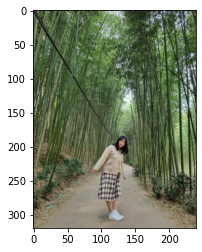

In [54]:
# 사진 준비하기(색깔 보정해서 준비)
my_image_path_3 = 'aiffel/camera_sticker/images/image_sy_4.png'
img_bgr_3 = cv2.imread(my_image_path_3) # OpenCV로 이미지 불러오기
img_show_3 = img_bgr_3.copy() # 출력용 이미지 따로 보관
img_rgb_3 = cv2.cvtColor(img_bgr_3, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_3) # 이미지 출력을 위해 출력할 이미지 올리기
plt.show()

rectangles[]


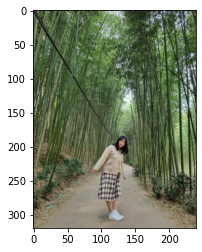

In [60]:
# dlib의 hog detector 선언
detector_hog = dlib.get_frontal_face_detector()

# detector_hog를 이용해 얼굴의 bounding box를 추출
dlib_rects = detector_hog(img_rgb_3, 1) # (image, num of image pyramid)

# 얼굴의 bounding box 찾기
print(dlib_rects)

# 찾은 얼굴 영역의 좌표
for dlib_rect in dlib_rects:
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽
    
    # 시작점의 좌표와 종료점 좌표를 직각 사각형으로 그리기
    cv2.rectangle(img_show_3, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show_3, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- 멀리서 찍은 사진은 얼굴이 너무 작게 나오고 주변 노이즈로 인해서 얼굴을 찾지 못하는 거 같다. bounding box조차 구할 수가 없었다.

### (3) 옆으로 누워서 촬영하면 왜 안되는가?

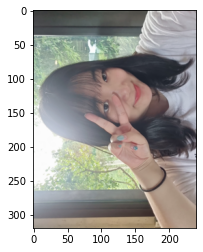

In [63]:
# 사진 준비하기(색깔 보정해서 준비)
my_image_path_4 = 'aiffel/camera_sticker/images/image_sy.png'
img_bgr_4 = cv2.imread(my_image_path_4) # OpenCV로 이미지 불러오기
img_bgr_rotate = cv2.rotate(img_bgr_4,cv2.ROTATE_90_COUNTERCLOCKWISE)
img_show_4 = img_bgr_rotate.copy() # 출력용 이미지 따로 보관
img_rgb_4 = cv2.cvtColor(img_bgr_4, cv2.COLOR_BGR2RGB)
img_rgb_rotate = cv2.rotate(img_rgb_4,cv2.ROTATE_90_COUNTERCLOCKWISE)
plt.imshow(img_rgb_rotate) # 이미지 출력을 위해 출력할 이미지 올리기
plt.show()

rectangles[]


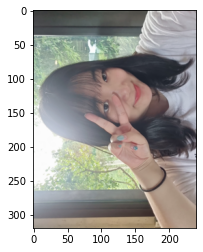

In [64]:
# dlib의 hog detector 선언
detector_hog = dlib.get_frontal_face_detector()

# detector_hog를 이용해 얼굴의 bounding box를 추출
dlib_rects = detector_hog(img_rgb_rotate, 1) # (image, num of image pyramid)

# 얼굴의 bounding box 찾기
print(dlib_rects)

# 찾은 얼굴 영역의 좌표
for dlib_rect in dlib_rects:
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽
    
    # 시작점의 좌표와 종료점 좌표를 직각 사각형으로 그리기
    cv2.rectangle(img_show_4, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show_4, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- 옆으로 누워서 찍으면 위의 사진처럼 왼쪽이나 오른쪽으로 90도 돌아간 사진으로 찍힌다. 그 점을 이용해서 아까 고양이 수염을 붙였던 사진을 왼쪽으로 90도 돌린 후 얼굴을 찾기 위해 bounding box를 설정하려고 했지만 왼쪽으로 90도 돌아간 사진에서 얼굴 찾는 것은 불가했다. 옆으로 돌아간 얼굴을 찾지 못하는 것은 dilb 설정 상의 문제인 거 같다. 위에서부터 눈, 코, 입이 있어야 하는데 그렇지 못하면 얼굴로 인식이 안되는 거 같다.

### (4) 실행 속도가 중요한가?
- 실행 속도가 빠를수록 좋다고 생각하기 때문에 실행 속도는 중요한 요소 중 하나이다. 실행 속도가 느리다면 카메라 스티커앱을 쓰는 유저에게 답답함과 불편함을 줄 것이다. 얼굴을 빠르게 인식하고 스티커를 입히는 작업이 빠를수록 좋다.

### (5) 스티커앱을 만들 때 정확도가 얼마나 중요한가?
- 스티커앱을 만들 때 정확도는 실행 속도보다 더 중요한 요소 중 하나라고 생각한다. 스티커앱을 만들 때 정확도가 떨어진다면 컴퓨터가 아닌 인간이 직접 편집으로 사진에 스티커를 입히는 것이 더 낫지 않을까 하는 생각이 들었다. 그리고 정확도가 떨어져서 고양이 수염을 붙이는데 머리에 스티커가 있다던가 턱에 스티터가 있다던가 한다면 굳이 스티커앱을 쓰는 효용이 없을 것이다. 

---------

## 회고
1. 얼굴 영역과 랜드마크를 정확하게 검출하고, 스티커 사진을 합성시키는 데 성공하였는가?  
확대된 얼굴이 1개만 있을 때에는 얼굴 영역과 랜드마크를 정확하게 검출하고 스티커 사진을 합성시키는 일이 그렇게 어려운 일은 아니었다. 하지만 확대된 얼굴이 3개로 늘어났을 때에는 얼굴 영역과 랜드마크까지는 정확하게 검출하였으나 얼굴 3개 모두 스티커 사진을 합성시키는 데 어려움을 겪었다. 얼굴 하나하나에 맞게 스티커를 조정해 합성시키기는 하였지만 더 효율적이고 좋은 방법이 있을 거 같다. 그래서 이 부분에 대해서는 더 찾아보고 노력해보기로 했다.  
2. 정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력하였는가?  
좌표를 조절해서 최대한 어울리도록 고양이 수염의 위치를 조정하기는 하였지만 직접 해보면서 조정하는 방법을 선택했기 때문에 수학적으로 좌표를 계산하는 방법을 더 알고 싶다. 완벽하게 파악은 못했지만 그래도 결과물에는 만족한다.  
3. 얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였는가?  
얼굴각도, 이미지 밝기, 촬영거리 등 여러 변수에 따른 사진들을 바탕으로 고양이 수염을 합성해보고 그 영향에 대해 파악해보고 발생한 문제에 대한 해결방법을 찾아보았다. 완벽하게 해결하지 못해서 더 찾아보고 적용하고 싶다. 그래도 문제를 해결하지는 못했지만 해결하기 위해 방법을 찾아보는 과정에서 더 배운 점이 있어 헛된 시간은 아니었다.
4. 프로젝트를 진행하면서 느낀 점 : 사진 편집과 관련된 노드가 나오면 항상 설레는 마음이 생긴다. 이번 프로젝트 역시 그랬다. lms를 많이 참고했지만 아직 해결하지 못한 문제들이 많았고, 이번 문제만큼은 꼭 해결하고 싶다는 생각이 들었다. 그리고 이번 프로젝트를 진행하면서 시도했던 것보다 더 다양한 것을 시도해보고 싶었다. 사진 각도와 상관없이 그리고 인물의 각도와 상관없이 스티커를 조정할 수 있도록 만들어보고 싶었고, 사람 뿐만 아니라 동물 사진에서 동물 얼굴 영역과 랜드마크를 검출해 스티커 사진을 합성해보고 싶은 생각도 들었다. 다양한 스티커를 합성해보고 싶기도 했다. 이런 것들을 완성할 수 있을만큼 더 공부하고 노력해야겠다.

## Reference
[cv2.rectangle](https://copycoding.tistory.com/146)  
[cv2.circle](https://copycoding.tistory.com/147)  
[np.where](https://jimmy-ai.tistory.com/46)  
[cv2.rotate](https://kimtaeuk0103.tistory.com/37)  
[cv2.getRotationMatrix2D](https://yunwoong.tistory.com/125)